In [23]:
%matplotlib inline

In [152]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib as mpl
import seaborn as sns
from graph_tool import GraphView
from graph_tool.draw import sfdp_layout, graph_draw
from sklearn.metrics import average_precision_score
from collections import OrderedDict, defaultdict
from matplotlib import pyplot as plt

from helpers import infected_nodes, cascade_source
from graph_helpers import load_graph_by_name, remove_filters, get_edge_weights, extract_edges, extract_nodes
from random_steiner_tree.util import from_gt
from viz_helpers import lattice_node_pos
from sample_pool import TreeSamplePool
from query_selection import PredictionErrorQueryGenerator, WeightedPredictionErrorQueryGenerator
from simulator import Simulator
from tree_stat import TreeBasedStatistics
from experiment import gen_input
from root_sampler import build_true_root_sampler
from inference import infection_probability

from viz_helpers import visualize, query_plot_setting, default_plot_setting, tree_plot_setting, set_cycler, InfectionProbabilityViz
from eval_helpers import get_scores_by_queries

In [46]:
graph = 'lattice-1024-sto'
graph_suffix = '_rev'
num_queries_to_show = 5
sampling_method = 'loop_erased'
obs_method = "0.2"
cascade_fraction = "0.25"
cascade_model = 'si'
dataset_id = '{}-m{}-s{}-o{}'.format(graph, cascade_model, cascade_fraction, obs_method)
cascade_dir = 'cascade-weighted/{}'.format(dataset_id)
fig_dirname = 'figs/inspect-query-process'

query_dir = 'outputs/queries-weighted/{}/{}/'.format(dataset_id, sampling_method)
probas_dir = 'outputs/inf_probas-weighted/{}/{}/'.format(dataset_id, sampling_method)
cascade_id = 80

In [47]:
g = load_graph_by_name(graph, weighted=True, suffix=graph_suffix)
if graph.startswith('lattice'):
    n = int(np.sqrt(g.num_vertices()))
    pos = lattice_node_pos(g, shape=(n, n))
else:
    pos = sfdp_layout(g)

load graph from data/lattice-1024-sto/graph_weighted_rev.gt


In [48]:
obs, c = pkl.load(open('{}/{}.pkl'.format(cascade_dir, cascade_id), 'rb'))[:2]
inf_nodes = infected_nodes(c)
source = cascade_source(c)

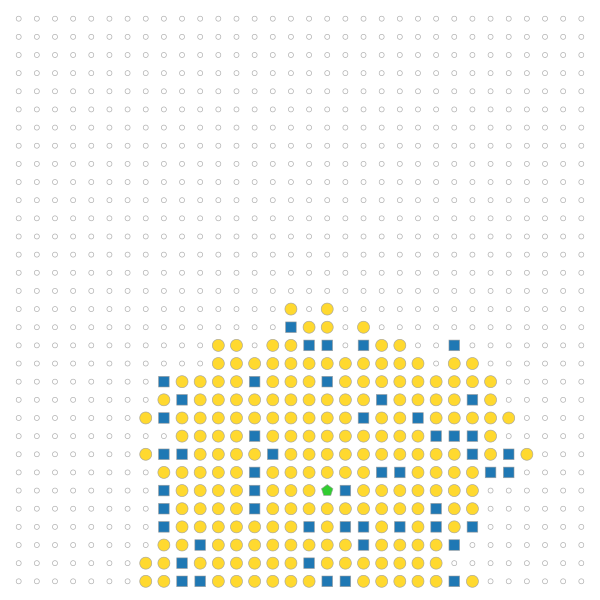

In [49]:
# plot cascade and observations

setting = default_plot_setting(g, c, obs)
visualize(g, pos, **setting, output='{}/cascade.pdf'.format(fig_dirname))


In [67]:
query_methods = ['random', 'pagerank', 'entropy', 'prediction_error', 'mutual-info']
query_method = 'prediction_error'
n_queries_to_show = 100

def load_qs_and_probas(query_method):
    query_file_path = os.path.join(query_dir, query_method, '{}.pkl'.format(cascade_id))
    proba_file_path = os.path.join(probas_dir, query_method, '{}.pkl'.format(cascade_id))
    qs, _ = pkl.load(open(query_file_path, 'rb'))
    qs = qs[:n_queries_to_show]
    probas = pkl.load(open(proba_file_path, 'rb'))
    return qs, probas



random


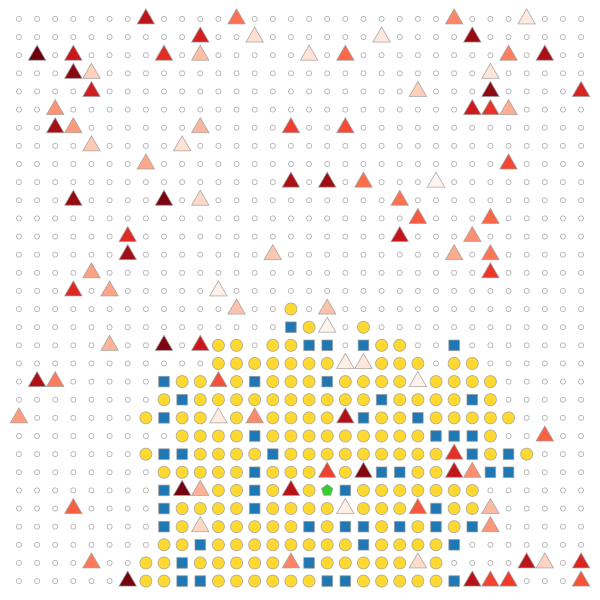

pagerank


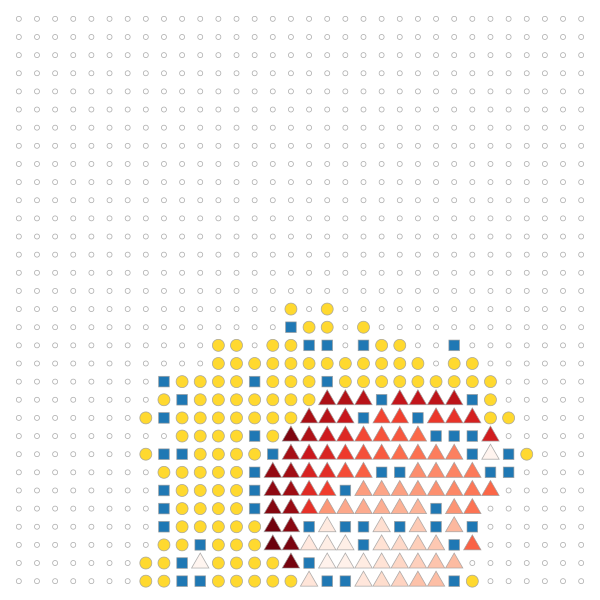

entropy


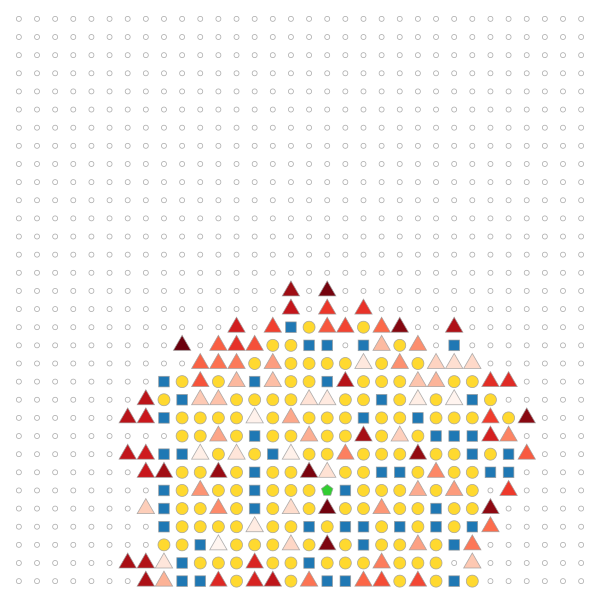

prediction_error


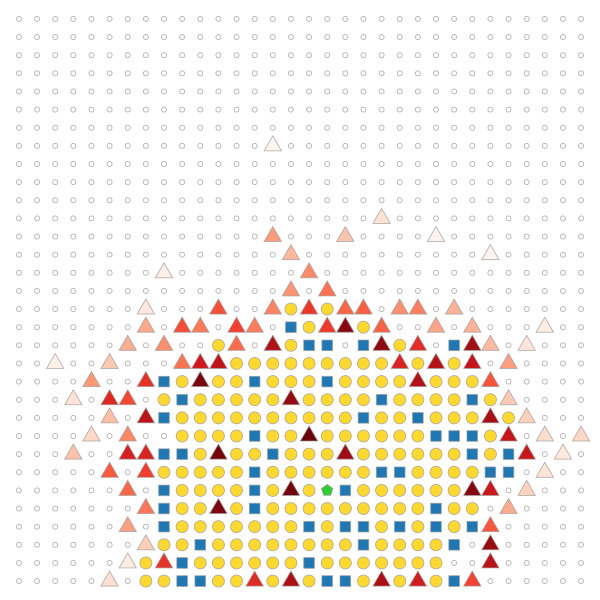

mutual-info


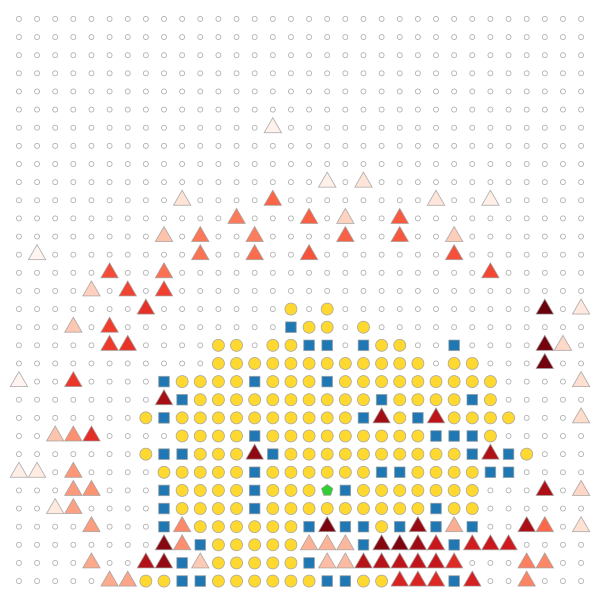

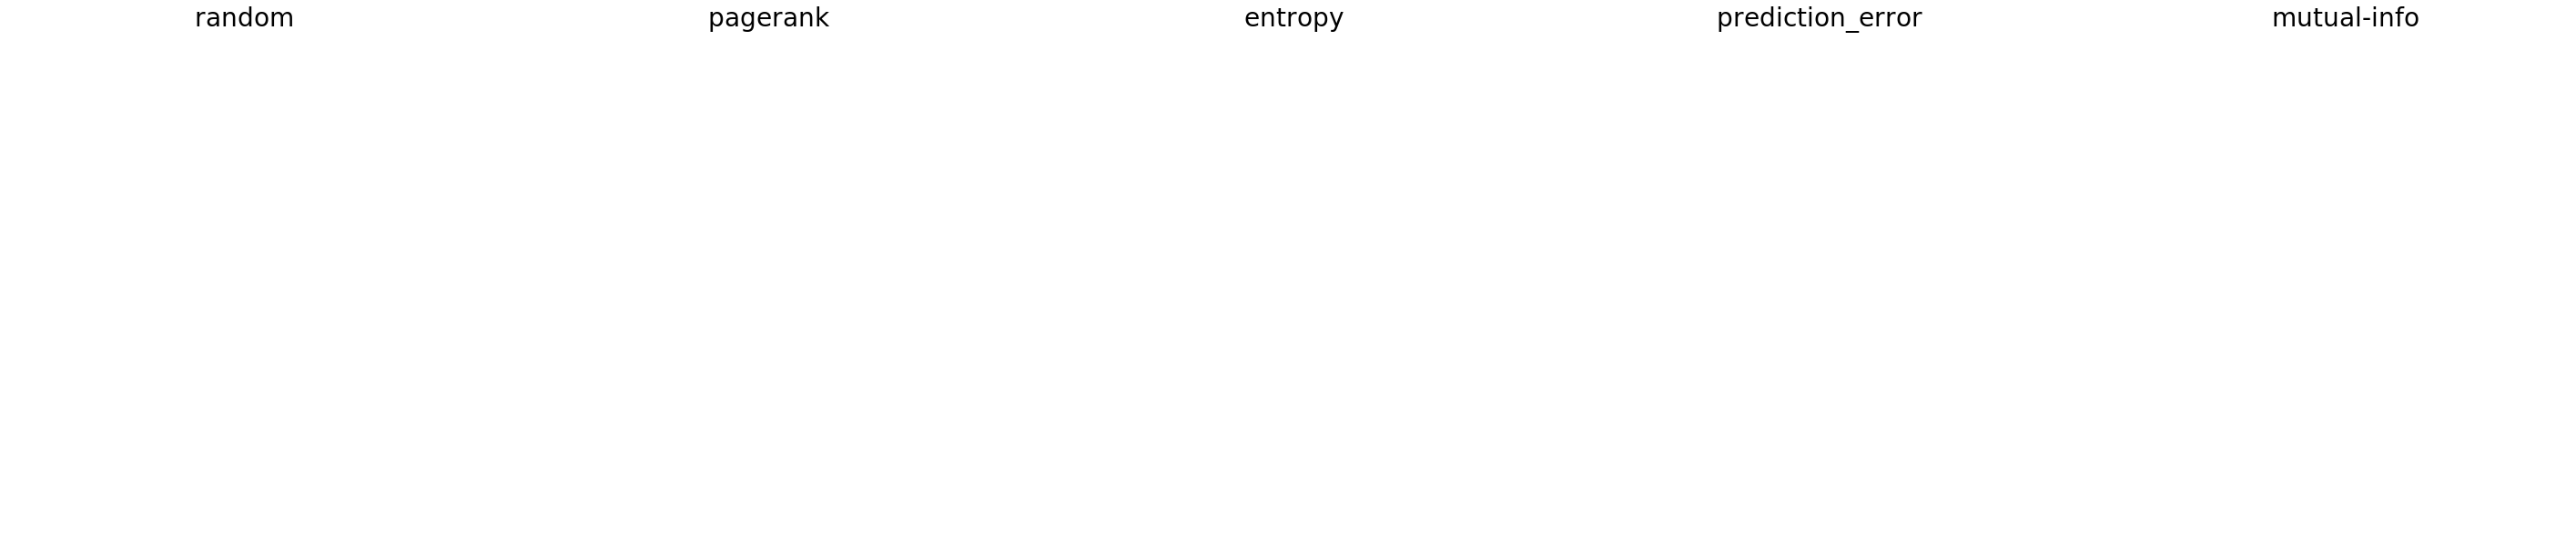

In [53]:
# plot the queries
plt.switch_backend('cairo')
size = 10
fig, axes = plt.subplots(1, len(query_methods), figsize=(size * len(query_methods), size))
for ax, query_method in zip(axes, query_methods):
    print(query_method)
    qs, probas = load_qs_and_probas(query_method)
    s = query_plot_setting(g, c, obs, qs, indicator_type=['color'])
    ax.set_title(query_method, fontdict={'fontsize': 28})    
    ax.axis('off')
    visualize(g, pos, **s, 
              # ax=ax,
              output='{}/queries-by-{}.pdf'.format(fig_dirname, query_method))

In [15]:
fig.savefig('{}/queries.pdf'.format(fig_dirname))

In [52]:
len(qs)

100

In [75]:
len(qs), len(probas)

(100, 101)

random 100 21
pagerank 100 21
entropy 100 21
prediction_error 100 21
mutual-info 100 21


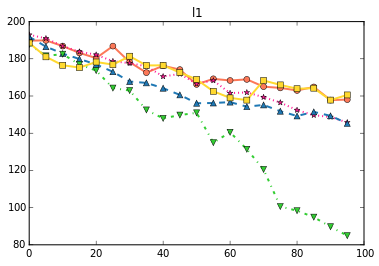

In [160]:
# plot the ap scores
score_list = defaultdict(list)

ax = plt.subplot()
set_cycler(ax)
eval_method = 'l1'
every = 5

for query_method in query_methods:
    qs, probas = load_qs_and_probas(query_method)
    probas = probas[0:1] + probas[1:int(len(qs) / every)+1]  # truncate probas 
    
    print(query_method, len(qs), len(probas))    

    def record_node_scores(scores):
        global score_list
        score_list[query_method].append(scores)    
        
    scores = get_scores_by_queries(qs, probas, c, obs, eval_method=eval_method,
                                   every=every,
                                   eval_with_mask=False,
                                   node_score_callback=record_node_scores)

    x = np.arange(0, len(scores)) * every
    ax.plot(x, scores)
# ax.legend(query_methods, loc='best')
ax.set_title(eval_method)

# ax.set_ylim(-0.05, 1.05)
plt.show()
plt.savefig('{}/{}_score.png'.format(fig_dirname, eval_method))


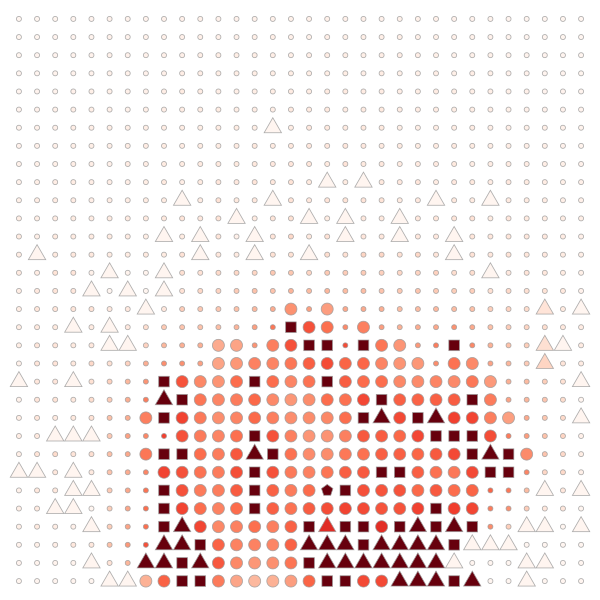

In [168]:
def intercept_f(setting):
    s = query_plot_setting(g, c, obs, qs, indicator_type=None)
    del s['node_color_info']
    setting.update(s)
viz.plot(c, obs, probas[int(n_queries_to_show / every)], interception_func=intercept_f)

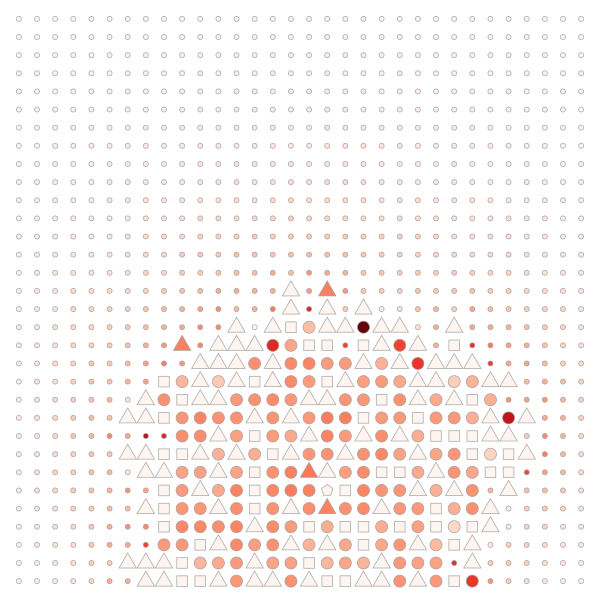

In [171]:
# plot loss

qs, probas = load_qs_and_probas('entropy')
viz = InfectionProbabilityViz(g, pos)
hidden_infs = set(inf_nodes) - (set(obs) | set(qs))
depth = score_list['entropy'][-1]
# depth = probas[int(n_queries_to_show / every)]
viz.plot(c, obs, depth, intercept_f)

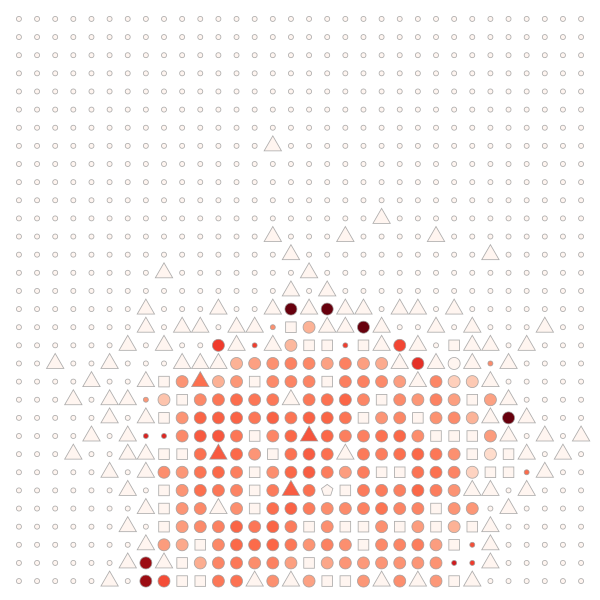

In [172]:
# plot loss

qs, probas = load_qs_and_probas('prediction_error')
viz = InfectionProbabilityViz(g, pos)
hidden_infs = set(inf_nodes) - (set(obs) | set(qs))
depth = score_list['prediction_error'][-1]
# depth = probas[int(n_queries_to_show / every)]
viz.plot(c, obs, depth, intercept_f)

In [131]:
gv = remove_filters(g)  # the reserved graph

weights = get_edge_weights(gv)
gi = from_gt(gv, weights=weights)

sampler = TreeSamplePool(
    gv,
    n_samples=2500,
    method=sampling_method,
    gi=gi,
    return_type='nodes',
    with_resampling=False,
    with_inc_sampling=False)

params = {'n_node_samples': None,
          'prune_nodes': True,
          'root_sampler': 'true_root',
          'root_sampler_eps': 0.0,
          'min_proba': 0.05,
          'n_node_samples': None,
          'error_estimator': TreeBasedStatistics(gv)}
q_gen = PredictionErrorQueryGenerator(gv, sampler, **params, verbose=True)
sim = Simulator(gv, q_gen, gi=gi, print_log=True)

In [143]:
n_queries_to_show = 10
qs_, _ = sim.run(n_queries_to_show, obs, c)

  0%|          | 0/10 [00:00<?, ?it/s]

pruning candidates from 1003 to 597
no estimation node sampling


 10%|█         | 1/10 [00:05<00:52,  5.87s/it]

update samples started
update samples done
pruning candidates from 596 to 559
no estimation node sampling


 20%|██        | 2/10 [00:10<00:44,  5.62s/it]

update samples started
update samples done
pruning candidates from 558 to 532
no estimation node sampling


 30%|███       | 3/10 [00:15<00:36,  5.22s/it]

update samples started
update samples done
pruning candidates from 531 to 508
no estimation node sampling


 40%|████      | 4/10 [00:19<00:29,  4.84s/it]

update samples started
update samples done
pruning candidates from 507 to 483
no estimation node sampling


 50%|█████     | 5/10 [00:22<00:22,  4.54s/it]

update samples started
update samples done
pruning candidates from 482 to 458
no estimation node sampling


 60%|██████    | 6/10 [00:26<00:16,  4.15s/it]

update samples started
update samples done
pruning candidates from 457 to 423
no estimation node sampling


 70%|███████   | 7/10 [00:28<00:11,  3.73s/it]

update samples started
update samples done
pruning candidates from 422 to 381
no estimation node sampling


 80%|████████  | 8/10 [00:31<00:06,  3.31s/it]

update samples started
update samples done
pruning candidates from 380 to 370
no estimation node sampling


 90%|█████████ | 9/10 [00:33<00:02,  2.98s/it]

update samples started
update samples done
pruning candidates from 369 to 358
no estimation node sampling
num. queries reached


In [144]:
query_scores = np.zeros(g.num_vertices())
for v, s in q_gen.query_scores.items():
    query_scores[int(v)] = s
query_scores[query_scores==0] = query_scores.max()  # make scores for observed maximum
query_scores -= query_scores.min() # from 0 to max-min
query_scores /= query_scores.max() # [0, 1]
if True:
    query_scores = 1 - query_scores  # invert it, the larger the score, the betterq


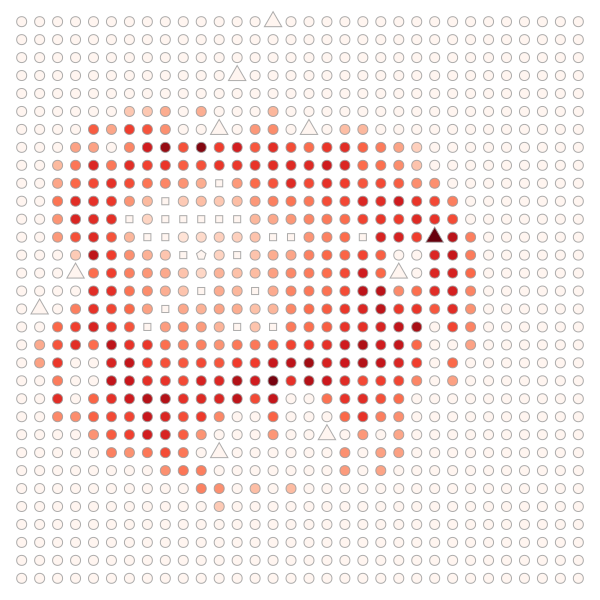

In [195]:
from viz_helpers import InfectionProbabilityViz
viz = InfectionProbabilityViz(g, pos)
def f(s):
    s['node_shape_info'][tuple(qs_)] = 'triangle'
    s['node_size_info'][tuple(qs_)] = 20
viz.plot(c, obs, query_scores, f,
         output='{}/query_score_{}.png'.format(fig_dirname, 'prederror'))


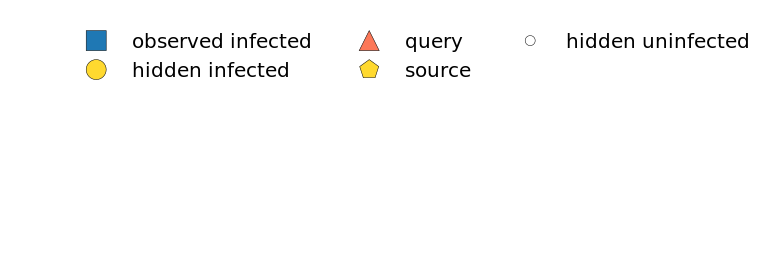